# Student Project - Machine Learning for Renewable Energy Systems
## Coding Track: Forecasting Building Energy Data

### Task: Predict demand of the next step, next day and next week of at least one building per category.



This notebook was created as project in the course of the seminar [Machine Learning for Renewable Energy Systems](https://www.mlsustainableenergy.com/teaching/machine-learning-for-renewable-energy-systems/) in the reserach group [
Machine Learning in Sustainable Energy Systems](https://www.mlsustainableenergy.com/) at the University of Tübingen. <br> 
The code and the forecasting has been carried out in this jupyter notebook and is the work of 

    Markus Deppner   4106780   markus.deppner@student.uni-tuebingen.de
    
This project works with data from ["The Building Data Genome 2 (BDG2) Data-Set"](https://github.com/buds-lab/building-data-genome-project-2) and aims to predict the energy demand of at least one building per category. To carry out this project I decided to train a Gaussian Process Regression Model for each individual building to forecast the demands of the next steps.  

This notebook ist designed in the following structure:

### Outline

* [1. Setup and Imports](#setup_section)
    - Import all necessary packages and define helper functions

* [2. Loading Datasets](#loading_datasets)
    - Load raw, cleaned and weather data
    - Load benchmarks
    
* [3. Specification of Constants](#constants)
    - Constants that are used throughout the project/notebook are defined in this section.

* [4. Gaussian Process Regression](#gpr)
    - [4.1 Helper Functions](#gpr_helper)
    - [4.2 Intermediate Computations](#gpr_compute)
        - Extract list of multiple grouped dataframes from complete dataframe
        - Split dataframe into list of train and test sets

* [5. Forecasting](#forecasting)
    - The actual forecasting using Gaussian Process Regression
    - Saving the files on the system
    
    
* [6. Evaluation](#evaluation)
    - Compare performance with benchmarks
    - Plot results


In addition to this notebook there is a second notebook which carries out the time consuming computation of the Spearman rank correlation matrix, for each building we want to forecast. It computes the correlation of the target dataframes to all other buildings and meter types. The correlation matrices are loaded into this notebook. Those buildings and metering types which show the highest correlation for the given target are used to train and predict the Gaussian Process Regression Mode. 

# <a name="setup_section"></a> 1. Setup: Manage Installations Imports and Helper Functions


During the setup phase of this project there have been problems with incompatibilities of numpy and
[GPy](https://github.com/SheffieldML/GPy) which is the library used for the Gaussian Process Regression.
In case you run into problems when executing the imports try to install the missing libraries via pip install. <br>
In case you have problems importing GPy try to update numpy and GPy to the newest version with the following statements

!pip install --upgrade GPy <br>
!pip install --upgrade numpy

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import csv
import GPy
import numpy as np
import pickle

from datetime import datetime
from glob import glob
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from scipy.stats import norm, percentileofscore


warning in stationary: failed to import cython module: falling back to numpy
warning in coregionalize: failed to import cython module: falling back to numpy
warning in choleskies: failed to import cython module: falling back to numpy


# <a name="loading_datasets"></a> 2. Load Datasets


This section loads the provided Data from the ["The Building Data Genome 2 (BDG2) Data-Set"](https://github.com/buds-lab/building-data-genome-project-2) and the benchmarks for this project

## Load metadata


In [2]:
metdata_path = "..\\data\\metadata\\"
metadata = pd.read_csv(metdata_path + "metadata.csv")


## Load weather data

In [3]:
# Weather data
weather_path = "..\\data\\weather\\"
weather = pd.read_csv(weather_path + "weather.csv")

In [4]:
# Convert timestamp field from string into pd.datetime object
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
weather['date'] = weather['timestamp'].dt.date
weather['month'] = weather['timestamp'].dt.month

In [5]:
weather.head()

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed,date,month
0,2016-01-01 00:00:00,Panther,19.4,NaN,19.4,0.0,NaN,NaN,0.0,0.0,2016-01-01,1
1,2016-01-01 01:00:00,Panther,21.1,6.0,21.1,-1.0,NaN,1019.4,0.0,0.0,2016-01-01,1
2,2016-01-01 02:00:00,Panther,21.1,NaN,21.1,0.0,NaN,1018.8,210.0,1.5,2016-01-01,1
3,2016-01-01 03:00:00,Panther,20.6,NaN,20.0,0.0,NaN,1018.1,0.0,0.0,2016-01-01,1
4,2016-01-01 04:00:00,Panther,21.1,NaN,20.6,0.0,NaN,1019.0,290.0,1.5,2016-01-01,1


## Load cleaned dataset


In [6]:
cleaned_meters_path = "..\\data\\meters\\cleaned\\"

# files in directory
files = glob(cleaned_meters_path + "*.csv")


In [7]:
dfs = [] # empty list of the dataframes to create
for file in files: # for each file in directory
    meter_type = file.split("\\")[4].split(".")[0] # meter_type to rename the value feature
    meter = pd.read_csv(file) # load the dataset
    meter = pd.melt(meter, id_vars = "timestamp", var_name = "building_id", value_name = "meter_reading") # melt dataset
    meter["meter"] = str(meter_type) # adds column with the meter type
    dfs.append(meter) # append to list
complete_data_cleaned = pd.concat(dfs, axis=0, ignore_index=True) # concatenate all meter
del(dfs, meter, file, files, meter_type)

complete_data_cleaned.head()


,timestamp,building_id,meter_reading,meter
0,2016-01-01 00:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
1,2016-01-01 01:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
2,2016-01-01 02:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
3,2016-01-01 03:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned
4,2016-01-01 04:00:00,Panther_office_Clementine,NaN,chilledwater_cleaned


In [8]:
# Note this cell might take some time to finish

# Convert timestamp field from string into pd.datetime object
complete_data_cleaned['timestamp'] = pd.to_datetime(complete_data_cleaned['timestamp'])

# Add column indicating the year, month and dayOfTheWeek for that timestamp
complete_data_cleaned['date'] = complete_data_cleaned['timestamp'].dt.date
complete_data_cleaned['year'] = complete_data_cleaned['timestamp'].dt.year
complete_data_cleaned['month'] = complete_data_cleaned['timestamp'].dt.month
complete_data_cleaned['dayOfWeek'] = complete_data_cleaned['timestamp'].dt.dayofweek


# Load benchmarks


In [9]:
benchmark_path = "..\\data\\"

# files in directory
files = glob(benchmark_path + "*.csv")


benchmark = pd.read_csv(files[0]) # load the dataset

benchmark

,name,building_id,RMSE,MAE,horizon
0,Bear_utility_Sidney,utility,1.157131,0.846614,hourly
1,Bear_utility_Sidney,utility,1.255013,0.862390,daily
2,Bear_utility_Sidney,utility,1.851878,1.167219,weekly
3,Cockatoo_religion_Diedre,religion,1.475301,1.018945,hourly
4,Cockatoo_religion_Diedre,religion,2.349360,1.820794,daily
5,Cockatoo_religion_Diedre,religion,2.833513,1.958076,weekly
6,Cockatoo_science_Rex,science,7.304536,5.529282,hourly
7,Cockatoo_science_Rex,science,10.882962,7.975783,daily
8,Cockatoo_science_Rex,science,12.667458,8.261340,weekly
9,Eagle_education_Teresa,education,8.286079,5.855556,hourly


In [10]:
# Get a list of buildingNames that need to be predicted and for which a benchmark is provided
buildingNames = benchmark['name'].unique()


#  <a name="constants"></a> 3. Specify Constants

Constants that are used throughout the project/notebook are defined in this section.
In order to obtain some of the constants we need to load a representative dataframe of one building for one meter_type.
In case to change some behaviour of the Gaussian Process ar the train and test data we need to modify the constants in this seciton

In [11]:
# We load the dataset with the first name building_name from the benchmarks as a representative dataframe
building_name = buildingNames[0]
representative_df = complete_data_cleaned.loc[(complete_data_cleaned['building_id'] == building_name)
                                               & (complete_data_cleaned['meter'] == 'electricity_cleaned')]

In [12]:
# Percentage of the test dataset the remaining percent will build the training dataset
TRAIN_TEST_SPLIT = 0.3

DATAPOINS_PER_BUILDING_AND_METER_TYPE = representative_df.shape[0]

# Defines the index at which we split our dataset
SPLIT_INDEX = int(DATAPOINS_PER_BUILDING_AND_METER_TYPE * (1 - TRAIN_TEST_SPLIT))

# Defines the timestamp which is the timestamp at whcih we split into train and test set
SPLIT_TIMESTAMP =  representative_df.iloc[SPLIT_INDEX]['timestamp']

# Dimensions/ Number of correlated dataframes to include in the Gaussian Process Regression model
GPR_DIMENSIONS = 5

SAMPLE_SIZE = 2000
DATAPOINTS_ONE_HOUR = 1
DATAPOINTS_ONE_DAY = 24
DATAPOINTS_ONE_WEEK = 24 * 7

# <a name="gpr"></a> 4. Gaussian Process Regression

In this section we define all the necessary helper functions for Gaussian Process Regressiona and intermediate computations, such that we can iterate in the last section over all buildings we want to predict 

## <a name="gpr_helper"></a> 4.1 Helper Functions

In [1]:
# Normalizes the data to a Gaussian distribution using quantiles. 
# The function needs to be transformed as the Gaussian Processes assumes data to be normal distributed

def normalize_to_gaussian(arr, mode="mean"):
    n = len(arr)
    perc = percentileofscore
    arr_ = arr.copy()[~np.isnan(arr)]
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.ppf(perc(arr_, arr[i], mode) / 100.)
        else:
            out[i] = np.nan
    return out


In [14]:

# Function that transforms the Gaussian normalisation back to percentiles of scores

def gaussian_to_cdf(arr):
    n = len(arr)
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.cdf(arr[i])
        else:
            out[i] = np.nan
            
    out = out
    
    return out

In [15]:
# This function is to compute the predictions which have been transformed to Gaussian distribution with the function 
def transform_into_original_range(arr, original):

    
    original_min = np.min(original)
    original_max = np.max(original)
    original_mean = np.nanmean(original) 
    original_std = np.nanstd(original)

    # Calculate the range, mean, and standard deviation of the predictions
    arr_range = np.max(arr) - np.min(arr)
    arr_mean = np.mean(arr)
    arr_std = np.std(arr)

    # Rescale the predictions based on the original signal's range and statistics
    rescaled = (
        (arr - arr_mean) * (original_std / arr_std) + original_mean
    )

    # Adjust the rescaled predictions to fit within the original signal's range
    min_diff = original_min - np.min(rescaled)
    max_diff = np.max(rescaled) - original_max
    if min_diff > 0:
        rescaled -= min_diff
    elif max_diff > 0:
        rescaled -= max_diff
 
    return rescaled

In [16]:
# Replaces missing values in the dataframe with the mean of the respective month over the whole timespan
def averageNaNs (df, field):
    mean_df = df.groupby(['month']).mean()
    mean_df['meter_reading'].fillna(mean_df['meter_reading'].mean(), inplace=True)
    if (len(mean_df.index) == 12):
        averaged_mean = df[field].copy().fillna(
                                    df['month'].map({1: mean_df[field][1] , 2: mean_df[field][2], 3:mean_df[field][3],
                                                     4: mean_df[field][4] , 5: mean_df[field][5], 6:mean_df[field][6], 
                                                     7: mean_df[field][7] , 8: mean_df[field][8], 9:mean_df[field][9],
                                                     10: mean_df[field][10] , 11: mean_df[field][11], 12:mean_df[field][12]}))
    else :
        averaged_mean = df[field].copy().fillna(
                                    df['month'].map({5: mean_df[field][5], 6:mean_df[field][6], 
                                                     7: mean_df[field][7] , 8: mean_df[field][8], 9: mean_df[field][9],
                                                     10: mean_df[field][10] , 11: mean_df[field][11], 12: mean_df[field][12]}))
    averaged_numpy = averaged_mean.to_numpy()
    return averaged_numpy

In [17]:
# Train a Gaussian Process model based on the training data

def trainGP (X_train, Y_train):
    
    # Shape of training data needs to be consistent 
    assert X_train.shape[0] == Y_train.shape[0]
    
    kernel = GPy.kern.RBF(input_dim=X_train.shape[1])
    model = GPy.models.GPRegression(X_train, Y_train, kernel)
    model.optimize(messages=True)
    model.optimize_restarts(num_restarts=5)
    
    return model

## Iteration over all buildings we want to predict

In [18]:
#! Probably not needed any longer!


# For given dataset (list of pd.Dataframes) we compute a subsample of those dataframes such that we obtain a list of dfs
# that do not fit the given building_name and are not of meter_type 'electricity_cleaned'
# Also we obtain the index/position of the dataframe that matches the building_id and is of type electricity_cleaned
def get_all_features(dataset, building_name):
    key_to_exclude = [building_name, 'electricity_cleaned']
    features = []
    index_of_df = np.nan
    for index, key in enumerate(group_keys):
        # as the key composes of two elements, the buildling_id and the meter_type we compare two arrays of strings, therefore we need the .all() 
        if(key == key_to_exclude).all():
            index_of_df = index
            continue
        features.append(dataset[index])
            
    return features, index_of_df

In [19]:
# Split a dataframe into train and test data according to a split_date

def split_df_to_train_and_test(df, split_date):
    df_train = df.loc[df['timestamp'] < split_date].copy().reset_index(drop=True) 
    df_test  = df.loc[df['timestamp'] >= split_date].copy().reset_index(drop=True)
    return df_train, df_test

In [20]:
# 
def sort_according_to_highest_correlation(spearmans_matrix):
    correlation_values = spearmans_matrix[:,0]
    clean_correlation_values = np.nan_to_num(correlation_values, 0)
    clean_abs_correlation_values = np.abs(clean_correlation_values)
    sorted_indices = np.argsort(clean_abs_correlation_values)[::-1]
    
    return sorted_indices

In [21]:
# For a dataset (list of pd.Dataframes) and a list of sorted indice
def transform_highest_correlated_dfs_to_gpr_data(list_of_dfs ,sorted_indices):
    transformed_features = []
    for ind in sorted_indices:
        
        if len(transformed_features) == GPR_DIMENSIONS:
            break
            
        temp_df = list_of_dfs[ind]
        temp_df_train, temp_df_test = split_df_to_train_and_test(temp_df, SPLIT_TIMESTAMP)
        
        if ((compute_percentage_of_nan_values(temp_df_train) > 0.3)
            or (compute_percentage_of_nan_values(temp_df_test)> 0.3)):
            continue
        
        
        avg_temp_arr = averageNaNs(temp_df, 'meter_reading')
        gauss_arr = normalize_to_gaussian(avg_temp_arr)
        transformed_features.append(gauss_arr)
    
    return np.column_stack((transformed_features))

        

In [22]:
def compute_percentage_of_nan_values(df):
    rows = df.shape[0]
    nans = np.isnan(df['meter_reading']).sum()
    
    return nans/rows
    

In [23]:
def random_sampling(X_train, y_train, num_samples=SAMPLE_SIZE, random_seed=42):
    np.random.seed(random_seed)

    indices = np.random.choice(len(X_train), size=num_samples, replace=False)
    X_samples = X_train[indices]
    y_samples = y_train[indices]

    return X_samples, y_samples

In [24]:
def load_spearmans_matrix (name): 
    with open('../data/correlations/correlation_matrix_{}.pkl'.format(name), 'rb') as inp:
        correlation_matrix = pickle.load(inp)
        
    return correlation_matrix

In [25]:
def save_gpr_predictions (mean, var, name):
    
    with open ('../data/predictions/mean_{}.pkl'.format(name), 'wb') as outp:
        pickle.dump(mean, outp, pickle.HIGHEST_PROTOCOL )
        
    with open ('../data/predictions/var_{}.pkl'.format(name), 'wb') as outp:
        pickle.dump(var, outp, pickle.HIGHEST_PROTOCOL )

In [26]:
def save_transformed_predictions (prediction_transformed, variance_transformed, original_transformed, name):
    with open ('../data/predictions/transformed/mean_{}.pkl'.format(name), 'wb') as outp:
        pickle.dump(prediction_transformed, outp, pickle.HIGHEST_PROTOCOL )
        
    with open ('../data/predictions/transformed/var_{}.pkl'.format(name), 'wb') as outp:
        pickle.dump(variance_transformed, outp, pickle.HIGHEST_PROTOCOL )
        
    with open ('../data/predictions/transformed/orig_{}.pkl'.format(name), 'wb') as outp:
        pickle.dump(original_transformed, outp, pickle.HIGHEST_PROTOCOL )

## Error computation

In [27]:
def compute_error_metrics(y_target, prediction):
    
    assert (y_target.shape == prediction.shape)
    
    if np.isnan(y_target).any():
        mask = ~np.isnan(y_target)
        mse = mean_squared_error(y_target[mask], prediction[mask])
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_target[mask], prediction[mask])
    
    else: 
        mse = mean_squared_error(y_target, prediction)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_target, prediction)

    
    return rmse, mae


In [28]:
def save_errors(rmse, mae, time_horizon, name):
    with open ('../data/errors/{}/rmse_{}.pkl'.format(time_horizon, name), 'wb') as outp:
        pickle.dump(rmse, outp, pickle.HIGHEST_PROTOCOL )
    
    with open ('../data/errors/{}/mae_{}.pkl'.format(time_horizon, name), 'wb') as outp:
        pickle.dump(mae, outp, pickle.HIGHEST_PROTOCOL )
    
    

## <a name="gpr_intermediate"></a>  4.2  Intermediate Computations

In [29]:
# This cell might take some time to finish

# Group the DataFrame by 'building_id' and 'meter_type'
complete_data_grouped = complete_data_cleaned.groupby(['building_id', 'meter'])

# Initialize an empty list to store the smaller DataFrames
dfs = []
df_keys = []

# Iterate over the groups and create smaller DataFrames
for group_key, group in complete_data_grouped:
    df_keys.append(group_key)
    dfs.append(group.copy()) 

In [30]:
group_keys = np.array(df_keys)

In [31]:
# Split the list of dataframes dfs into two lists which contain the training and test data respectively
dfs_train = []
dfs_test = []

for df in dfs: 
    
    temp_train_df, temp_test_df = split_df_to_train_and_test(df, SPLIT_TIMESTAMP)
    dfs_train.append(temp_train_df)
    dfs_test.append(temp_test_df)
        

In [32]:
del(dfs)

# <a name="forecasting"></a> 5. Electricity Demand Forecasting with Gaussian Process Regression

In [33]:
# Load extension to get notifications once the cell finished executing
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [34]:
%%notify

for name in buildingNames: 
    print(name)
    
    # Get dataframe that matches our building_id
    df = complete_data_cleaned.loc[complete_data_cleaned['building_id']  == name]
    
    # For later reconstruction we split the electricity meter reading into train and test set
    y_train_df, y_test_df = split_df_to_train_and_test(df, SPLIT_TIMESTAMP)
    
    
    print("Load spearmans_matrix")
    spearmans_matrix = load_spearmans_matrix(name)
    
    
    # Sort according to highest correlation
    sorted_indices = sort_according_to_highest_correlation(spearmans_matrix)
    
    
    print("transforming highest correlated dfs")
   
    # Bring data into format to fit as GP Regression input (normal distribution)
    X_train = transform_highest_correlated_dfs_to_gpr_data(dfs_train, sorted_indices)
    X_test = transform_highest_correlated_dfs_to_gpr_data(dfs_test, sorted_indices)
  
    # ALso transform target data
    Y_train = normalize_to_gaussian(averageNaNs(y_train_df, 'meter_reading'))
    Y_test = normalize_to_gaussian(averageNaNs(y_test_df, 'meter_reading'))
 
    
    # Randomly sample from the datapoints, as we cannot train on the whole dimensions
    sampled_X_train, sampled_Y_train = random_sampling(X_train, Y_train)
            
    
    print("Training model ....")
    # Train the model 
    model = trainGP (sampled_X_train, sampled_Y_train.reshape(-1,1))
    
    print("Compute predictions ...")
    # Make predictions with the trained model for one week
    mean, var = model.predict(X_test[0:DATAPOINTS_ONE_WEEK])
    
    save_gpr_predictions(mean, var, name)
    
    
    print("transform predictions back to original data range")
    # Transform the predictions which take place in the gaussian domain back to the original data range
    prediction_transformed = transform_into_original_range(mean.flatten(), y_train_df['meter_reading'])
    variance_transformed = transform_into_original_range(var.flatten(), y_train_df['meter_reading'])
    original_test_transformed = transform_into_original_range(y_test_df['meter_reading'][:DATAPOINTS_ONE_WEEK], y_train_df['meter_reading'])
    
    save_transformed_predictions(prediction_transformed, variance_transformed, original_test_transformed, name)

    print("Compute errors ...")
    print("Hourly")
    #Compute the error values for each timespan hour, day, week
    rmse_hour, mae_hour = compute_error_metrics(y_test_df['meter_reading'][:DATAPOINTS_ONE_HOUR].to_numpy(), 
                                                          prediction_transformed[:DATAPOINTS_ONE_HOUR])
    save_errors(rmse_hour, mae_hour, 'hour', name)
    
    print("Daily")
    rmse_day, mae_day = compute_error_metrics(y_test_df['meter_reading'][:DATAPOINTS_ONE_DAY].to_numpy(), 
                                                       prediction_transformed[:DATAPOINTS_ONE_DAY])
    save_errors(rmse_day, mae_day, 'day', name)
    
    print("Weekly")
    rmse_week, mae_week = compute_error_metrics(y_test_df['meter_reading'][:DATAPOINTS_ONE_WEEK].to_numpy(), 
                                                          prediction_transformed[:DATAPOINTS_ONE_WEEK])

    save_errors(rmse_week, mae_week, 'week', name)

Bear_utility_Sidney
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1838.7310069419877
Optimization restart 2/5, f = 1838.7310069605896
Optimization restart 3/5, f = 1838.7310074772581
Optimization restart 4/5, f = 1838.7310078833912
Optimization restart 5/5, f = 1838.7310069654136
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Cockatoo_religion_Diedre
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1526.9655791899365
Optimization restart 2/5, f = 1526.9655791911227
Optimization restart 3/5, f = 1526.9655791926052
Optimization restart 4/5, f = 1526.9655792028298
Optimization restart 5/5, f = 1526.9655791919677
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Cockatoo_science_Rex
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1475.2041899229644
Optimization restart 2/5, f = 1475.2041899234068
Optimization restart 3/5, f = 1475.2041899229357
Optimization restart 4/5, f = 1475.2041899391397
Optimization restart 5/5, f = 1475.204189992152
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Eagle_education_Teresa
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1571.3521458412738
Optimization restart 2/5, f = 1571.3521458443556
Optimization restart 3/5, f = 1571.3521458364453
Optimization restart 4/5, f = 1571.352145835628
Optimization restart 5/5, f = 1571.3521458386094
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Eagle_health_Lucinda
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 2026.4237274054851
Optimization restart 2/5, f = 2026.4237274035331
Optimization restart 3/5, f = 2026.423727400138
Optimization restart 4/5, f = 2026.4237274814268
Optimization restart 5/5, f = 2026.4237273993715
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Fox_food_Francesco
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1951.35132442664
Optimization restart 2/5, f = 1951.3513244250203
Optimization restart 3/5, f = 1951.351324425743
Optimization restart 4/5, f = 1951.3513244690316
Optimization restart 5/5, f = 1951.351324428616
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Fox_parking_Tommie
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1590.0261906070004
Optimization restart 2/5, f = 1590.026190661229
Optimization restart 3/5, f = 1590.0261906068358
Optimization restart 4/5, f = 1590.0261907217878
Optimization restart 5/5, f = 1590.026190609716
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Gator_other_Gertrude
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1746.2468632410325
Optimization restart 2/5, f = 1746.2468632449388
Optimization restart 3/5, f = 1746.2468632335504
Optimization restart 4/5, f = 1746.246863234395
Optimization restart 5/5, f = 1746.2468632632454
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Hog_office_Bill
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 823.0520109169406
Optimization restart 2/5, f = 823.0520109661688
Optimization restart 3/5, f = 823.0520109208632
Optimization restart 4/5, f = 823.0520109169397
Optimization restart 5/5, f = 823.0520109178572
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Hog_services_Kerrie
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1792.5484565953611
Optimization restart 2/5, f = 1792.548456600384
Optimization restart 3/5, f = 1792.548456594186
Optimization restart 4/5, f = 1792.5484565954985
Optimization restart 5/5, f = 1792.548456594173
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Hog_warehouse_Porsha
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1168.5492001252394
Optimization restart 2/5, f = 1168.549200125819
Optimization restart 3/5, f = 1168.5492001263333
Optimization restart 4/5, f = 1168.549200128607
Optimization restart 5/5, f = 1168.549200125381
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Lamb_assembly_Bertie
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 787.4777904227038
Optimization restart 2/5, f = 787.4777904167233
Optimization restart 3/5, f = 787.4777904167131
Optimization restart 4/5, f = 787.4777904176793
Optimization restart 5/5, f = 787.4777904167418
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Lamb_industrial_Carla
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1179.6575131798922
Optimization restart 2/5, f = 1179.6575131798636
Optimization restart 3/5, f = 1179.657513197109
Optimization restart 4/5, f = 1179.657513179825
Optimization restart 5/5, f = 1179.657513184495
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Peacock_lodging_Matthew
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 2277.5764930610844
Optimization restart 2/5, f = 2277.5764930542837
Optimization restart 3/5, f = 2277.5764930608125
Optimization restart 4/5, f = 2277.576493054614
Optimization restart 5/5, f = 2277.5764930614664
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Rat_public_Loretta
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1269.5722341590613
Optimization restart 2/5, f = 1269.5722341686658
Optimization restart 3/5, f = 1269.572234174639
Optimization restart 4/5, f = 1269.5722341591154
Optimization restart 5/5, f = 1269.572234163199
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly
Wolf_retail_Marcella
Load spearmans_matrix
transforming highest correlated dfs


 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value encountered in longlong_scalars
 C:\Users\marku\AppData\Local\Temp\ipykernel_13092\2278653229.py:5: RuntimeWarning:invalid value 

Training model ....


Optimization restart 1/5, f = 1824.3329968281982
Optimization restart 2/5, f = 1824.3329968397754
Optimization restart 3/5, f = 1824.3329968662001
Optimization restart 4/5, f = 1824.3329968406506
Optimization restart 5/5, f = 1824.332996828664
Compute predictions ...
transform predictions back to original data range
Compute errors ...
Hourly
Daily
Weekly


<IPython.core.display.Javascript object>

In [37]:
with open('../data/predictions/transformed/mean_Eagle_health_Lucinda.pkl', 'rb') as inp:
        trans_mean = pickle.load(inp)
        
with open('../data/predictions/transformed/var_Eagle_health_Lucinda.pkl', 'rb') as inp:
        trans_var = pickle.load(inp)
        
with open('../data/predictions/transformed/orig_Eagle_health_Lucinda.pkl', 'rb') as inp:
        trans_orig = pickle.load(inp)
        

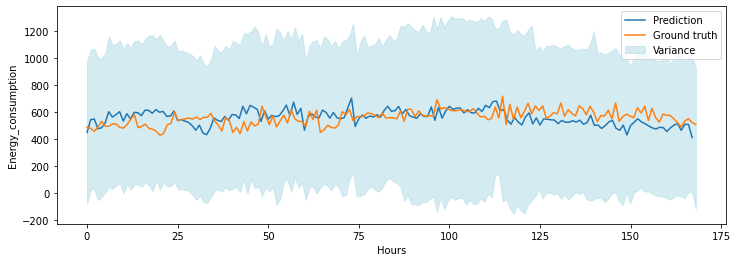

In [38]:

x = np.linspace(0, np.size(trans_mean), np.size(trans_mean))

plt.figure(figsize=(12,4))
plt.xlabel('Hours')
plt.ylabel('Energy_consumption')

plt.plot(trans_mean, label='Prediction')
plt.plot(x, trans_orig[0:200], label='Ground truth')
plt.fill_between(x, (trans_mean - trans_var).flatten(), (trans_mean + trans_var).flatten(), color='lightblue', alpha=0.5, label='Variance')
plt.legend()
plt.show()

In [40]:
trans_orig

0      490.339277
1      479.744561
2      458.555129
3      490.339277
4      532.718142
          ...    
163    490.339277
164    535.366821
165    551.258895
166    524.772105
167    508.880031
Name: meter_reading, Length: 168, dtype: float64

In [42]:
rmses = []
maes = []


for name in buildingNames:
            
    with open('../data/errors/day/rmse_{}.pkl'.format(name), 'rb') as inp:
        rmse = pickle.load(inp)
        rmses.append(rmse)
        
    with open('../data/errors/day/mae_{}.pkl'.format(name), 'rb') as inp:
        mae = pickle.load(inp)
        maes.append(mae)


In [56]:
rmses[3]

239721.29273872302

In [57]:
maes[3]

230272.4821551476

In [53]:
benchmark

,name,building_id,RMSE,MAE,horizon
0,Bear_utility_Sidney,utility,1.157131,0.846614,hourly
1,Bear_utility_Sidney,utility,1.255013,0.862390,daily
2,Bear_utility_Sidney,utility,1.851878,1.167219,weekly
3,Cockatoo_religion_Diedre,religion,1.475301,1.018945,hourly
4,Cockatoo_religion_Diedre,religion,2.349360,1.820794,daily
5,Cockatoo_religion_Diedre,religion,2.833513,1.958076,weekly
6,Cockatoo_science_Rex,science,7.304536,5.529282,hourly
7,Cockatoo_science_Rex,science,10.882962,7.975783,daily
8,Cockatoo_science_Rex,science,12.667458,8.261340,weekly
9,Eagle_education_Teresa,education,8.286079,5.855556,hourly


In [44]:
np.argwhere(buildingNames == 'Eagle_health_Lucinda')

array([[4]], dtype=int64)

## Specify and Train Gaussian Process model

###### Plot the results given driectly from the GP

Note as we previously transformed the data to be normal distributed, the data we obtain here is as well transformed <br>
In order to reconstruct the original data we need to transform it back

In [ ]:
'''
x = np.linspace(0, np.size(mean), np.size(mean))

plt.figure(figsize=(12,4))
plt.xlabel('Hours')
plt.ylabel('Energy_consumption')

plt.plot(x, mean, label='Prediction')
plt.plot(x, test_meter[0:200], label='Ground truth')
plt.fill_between(x, (mean - var).flatten(), (mean + var).flatten(), color='lightblue', alpha=0.5, label='Variance')
plt.legend()
plt.show()
'''

## Convert the results back and compare them

In [ ]:
'''
prediction_transformed = transform_into_original_range(mean.flatten(), original_data_train)
variance_transformed = transform_into_original_range(var.flatten(), original_data_train)
original_test_transformed = transform_into_original_range(original_data_test[0:200], original_data_train)
'''

In [ ]:
'''
x = np.linspace(0, np.size(prediction_transformed), np.size(prediction_transformed))

plt.figure(figsize=(12,4))
plt.xlabel('Hours')
plt.ylabel('Energy_consumption')

plt.plot(x, prediction_transformed, label='Prediction')
plt.plot(x, original_data_test[0:200], label='Ground truth')
plt.legend()
plt.show()
'''